In [30]:
# =============================
# Symmetry-Constrained PINN-RNN
# FINAL Synthetic Research Code (v3 full)
# =============================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

# --------------------
# Device
# --------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------
# Parameters
# --------------------
T, S, K, N = 10, 4, 40, 20    # sessions, trials, bins, neurons
rank = 3                      # low-rank drift dimension
epochs = 11
batch_size = 4


# --------------------
# Synthetic dataset
# --------------------
class SyntheticDataset(Dataset):
    def __init__(self):
        self.x = torch.randn(T, S, K, N)
        self.v = torch.rand(T, S, K)
        self.u = torch.rand(T, S, K)
        self.W0 = 0.1 * torch.randn(N, N)
        U, _, Vt = torch.linalg.svd(self.W0)
        self.U = U[:, :rank]
        self.V = Vt[:rank, :].T
        self.S = S  # ✅ store S for later
        assert self.U.shape == (N, rank)
        assert self.V.shape == (N, rank)

    def __len__(self):
        return T * self.S  # ✅ use self.S

    def __getitem__(self, idx):
        t = idx // self.S   # ✅ use self.S
        s = idx % self.S
        return (self.x[t, s], self.v[t, s], self.u[t, s], t)


data = SyntheticDataset()


# --------------------
# Model
# --------------------
class SlowODE(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(r + 1, 64),
            nn.Tanh(),
            nn.Linear(64, r)
        )

    def forward(self, t, z):
        if isinstance(t, torch.Tensor):
            t = t.item()
        tvec = torch.full_like(z[:, :1], t)
        return self.net(torch.cat([z, tvec], dim=1))

class PINN_RNN(nn.Module):
    def __init__(self, N, r, U, V, W0, b_fixed = None):
        super().__init__()
        self.U = U.to(device)
        self.V = V.to(device)
        self.W0 = W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(r))
        self.slow = SlowODE(r)
        self.B = nn.Parameter(torch.randn(N, 1) * 0.01)
        # self.b = nn.Parameter(torch.zeros(N)) 
        self.b_fixed = b_fixed.to(device)  # fixed bias (excitablity)
        self.R = nn.Parameter(torch.randn(1, N) * 0.01)

    def rnn_cell(self, x, v, W):
        # return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b)
        return torch.tanh((W @ x) + (self.B * v).squeeze() + self.b_fixed) 

    def weights_over_time(self, T):
        times = torch.arange(T, dtype=torch.float32, device="cpu")
        z0_cpu = self.z0.unsqueeze(0).float().cpu()
        z_cpu = odeint(self.slow.cpu(), z0_cpu, times).squeeze(1).to(device)
        return self.W0 + self.U @ torch.diag_embed(z_cpu) @ self.V.T

    def forward(self, x0, v, t, Ws):
        W = Ws[t]
        K, N = x0.shape
        x_list = [x0[0]]
        rec = dec = upd = sym = 0
        for k in range(K - 1):
            up = self.rnn_cell(x_list[k], v[k], W)
            rec += (x_list[k] - x0[k]).pow(2).sum()
            dec += (self.R @ x_list[k] - v[k].unsqueeze(0)).pow(2).sum()
            upd += (up - self.rnn_cell(x_list[k], v[k], W)).pow(2).sum()
            x_list.append(up)
        return rec, dec, upd, sym

# --------------------
# Training
# --------------------
b_fixed = data.x.mean(dim=(0,1,2)).to(device)  # shape: (N,)
model = PINN_RNN(N, rank, data.U, data.V, data.W0, b_fixed=b_fixed).to(device)
# model = PINN_RNN(N, rank, data.U, data.V, data.W0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
initial_R = model.R.detach().clone()
initial_B = model.B.detach().clone()
# loss_history = {"rec": [], "dec": [], "upd": [], "sym": [], "smooth": []}
loss_history = {"rec": [], "dec": [], "upd": []}


for ep in range(epochs):
    Ws = model.weights_over_time(T).detach()
    Ltot = 0
    for x, v, u, t in loader:
        x, v, u, t = x.to(device), v.to(device), u.to(device), t.to(device)
        batch_loss = 0
        for i in range(x.shape[0]):
            R, D, U, S = model(x[i], v[i], t[i], Ws)
            loss_history["rec"].append(R.item())
            loss_history["dec"].append(D.item())
            loss_history["upd"].append(U.item())
            # loss_history["sym"].append(S.item())
            batch_loss += R + D + 0.01 * U
        batch_loss /= x.shape[0]
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        Ltot += batch_loss.item()
    if ep % 10 == 0:
        print(f"Epoch {ep:3d}  Loss {Ltot/len(loader):.4f}")

print("✅ Synthetic training completed.")

Ws = model.weights_over_time(T).detach()  # ✅ add this



Using device: mps
Epoch   0  Loss 794.3877
Epoch  10  Loss 792.7444
✅ Synthetic training completed.


In [31]:
import torch
import numpy as np
import os

# 1) create a folder for checkpoints / results
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 2) save a PyTorch checkpoint
torch.save({
    "epoch": epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "initial_R": initial_R.detach().cpu(),
    "initial_B": initial_B.detach().cpu(),
    "T": T, "S": S, "K": K, "N": N,
}, "checkpoints/pinn_rnn_checkpoint.pth")

# 3) save NumPy arrays & Python dicts
# np.savez(
#     "results/pinn_rnn_results.npz",
#     # final drifting weights
#     Ws = Ws.cpu().numpy(),          # shape (T, N, N)
#     # loss history arrays
#     loss_rec    = np.array(loss_history["rec"]),
#     loss_dec    = np.array(loss_history["dec"]),
#     loss_upd    = np.array(loss_history["upd"]),
#     loss_sym    = np.array(loss_history["sym"]),
#     loss_smooth = np.array(loss_history["smooth"]),
#     # initial read-out and input weights
#     R0 = initial_R.detach().cpu().numpy(),   # shape (1, N)
#     B0 = initial_B.detach().cpu().numpy(),   # shape (N, 1)
#     # hyperparameters
#     T = T, S = S, K = K, N = N
# )
np.savez(
    "results/pinn_rnn_results.npz",
    Ws = Ws.cpu().numpy(),
    loss_rec    = np.array(loss_history["rec"]),
    loss_dec    = np.array(loss_history["dec"]),
    loss_upd    = np.array(loss_history["upd"]),
    R0 = initial_R.detach().cpu().numpy(),
    B0 = initial_B.detach().cpu().numpy(),
    T = T, S = S, K = K, N = N
)




# 4) (optional) pickle your dataset metadata if you constructed it in‐memory
import pickle
with open("results/dataset_meta.pkl","wb") as f:
    pickle.dump({
        "device": str(device),
        "dataset_shape": data.x.shape,   # (T,S,K,N)
    }, f)


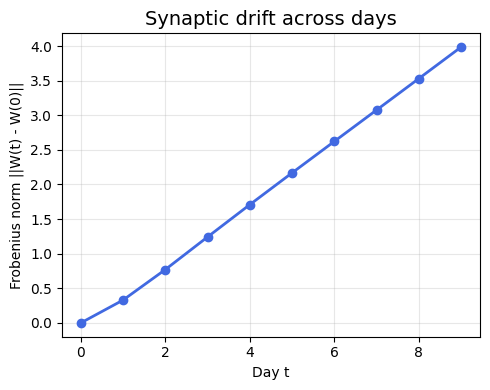

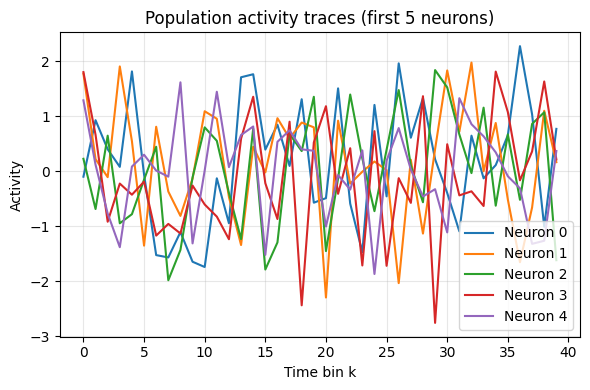

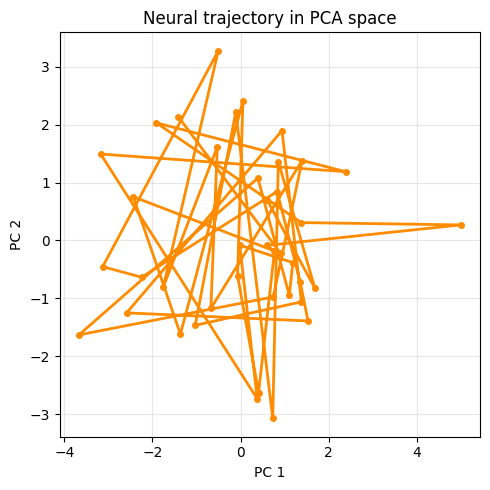

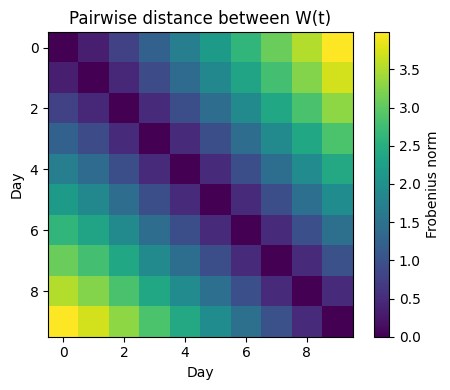

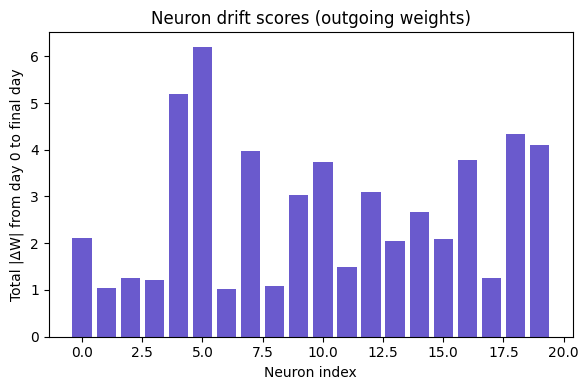

In [32]:
import matplotlib.pyplot as plt

def plot_weight_drift_fancy(Ws):
    """Improved synaptic drift plot with labels + grid + style."""
    T = Ws.shape[0]
    diffs = [torch.norm(Ws[t] - Ws[0]).item() for t in range(T)]
    plt.figure(figsize=(5,4))
    plt.plot(range(T), diffs, marker='o', linewidth=2, color='royalblue')
    plt.xlabel("Day t")
    plt.ylabel("Frobenius norm ||W(t) - W(0)||")
    plt.title("Synaptic drift across days", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_neuron_population_trajectory(x_trial, num_neurons=5):
    """Plot several neuron activity traces for 1 trial."""
    plt.figure(figsize=(6,4))
    for i in range(num_neurons):
        plt.plot(x_trial[:, i].cpu().numpy(), label=f"Neuron {i}")
    plt.xlabel("Time bin k")
    plt.ylabel("Activity")
    plt.title(f"Population activity traces (first {num_neurons} neurons)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


from sklearn.decomposition import PCA

def plot_pca_trajectory(x_trial):
    """PCA trajectory of neural population during 1 trial."""
    x = x_trial.cpu().numpy()
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x)
    plt.figure(figsize=(5,5))
    plt.plot(x_pca[:,0], x_pca[:,1], '-o', linewidth=2, markersize=4, color='darkorange')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Neural trajectory in PCA space")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



def plot_weight_distance_matrix(Ws):
    """Heatmap of distance between all W(t) matrices."""
    T = Ws.shape[0]
    dist = np.zeros((T, T))
    for i in range(T):
        for j in range(T):
            dist[i,j] = torch.norm(Ws[i]-Ws[j]).item()
    plt.figure(figsize=(5,4))
    plt.imshow(dist, cmap='viridis')
    plt.colorbar(label="Frobenius norm")
    plt.title("Pairwise distance between W(t)")
    plt.xlabel("Day")
    plt.ylabel("Day")
    plt.tight_layout()
    plt.show()



def plot_neuron_drift_bar(Ws):
    """Barplot of neuron-wise drift scores based on weight changes."""
    delta_W = Ws[-1] - Ws[0]
    drift = delta_W.abs().sum(dim=1).cpu().numpy()   # sum over outgoing weights
    plt.figure(figsize=(6,4))
    plt.bar(range(len(drift)), drift, color='slateblue')
    plt.xlabel("Neuron index")
    plt.ylabel("Total |ΔW| from day 0 to final day")
    plt.title("Neuron drift scores (outgoing weights)")
    plt.tight_layout()
    plt.show()


# ------------------------------------------
# After training finishes → diagnostics plots
# ------------------------------------------

# recompute Ws from final model
Ws = model.weights_over_time(T).detach()

# 1️⃣ Drift over days
plot_weight_drift_fancy(Ws)

# 2️⃣ Population activity traces for a random trial
sample_x = data.x[0, 0]   # session 0, trial 0
plot_neuron_population_trajectory(sample_x, num_neurons=5)

# 3️⃣ PCA manifold trajectory for same trial
plot_pca_trajectory(sample_x)

# 4️⃣ Pairwise distance heatmap of W(t)
plot_weight_distance_matrix(Ws)

# 5️⃣ Neuron drift scores across days
plot_neuron_drift_bar(Ws)



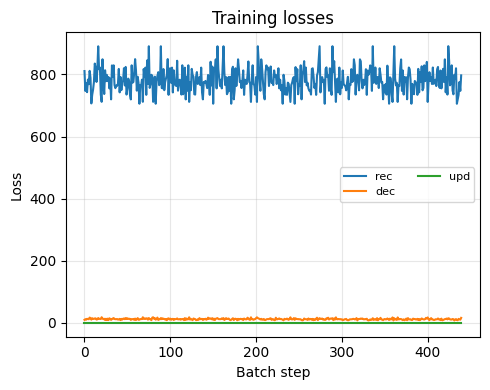

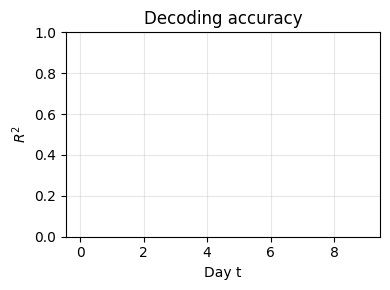

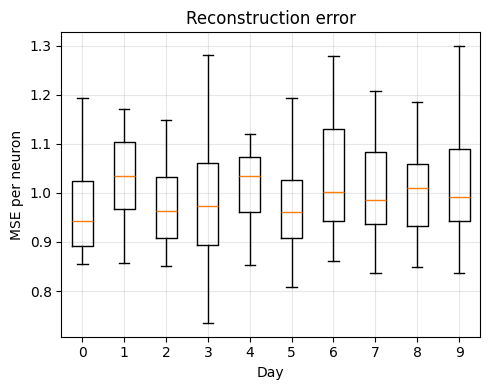

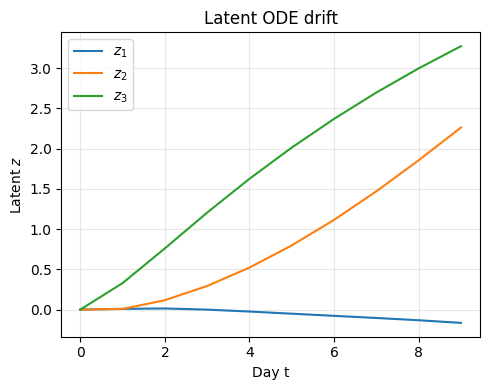

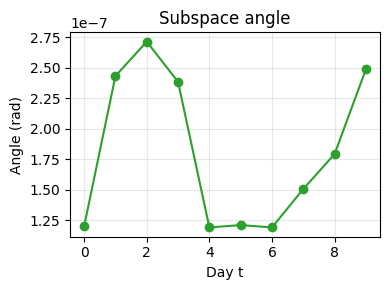

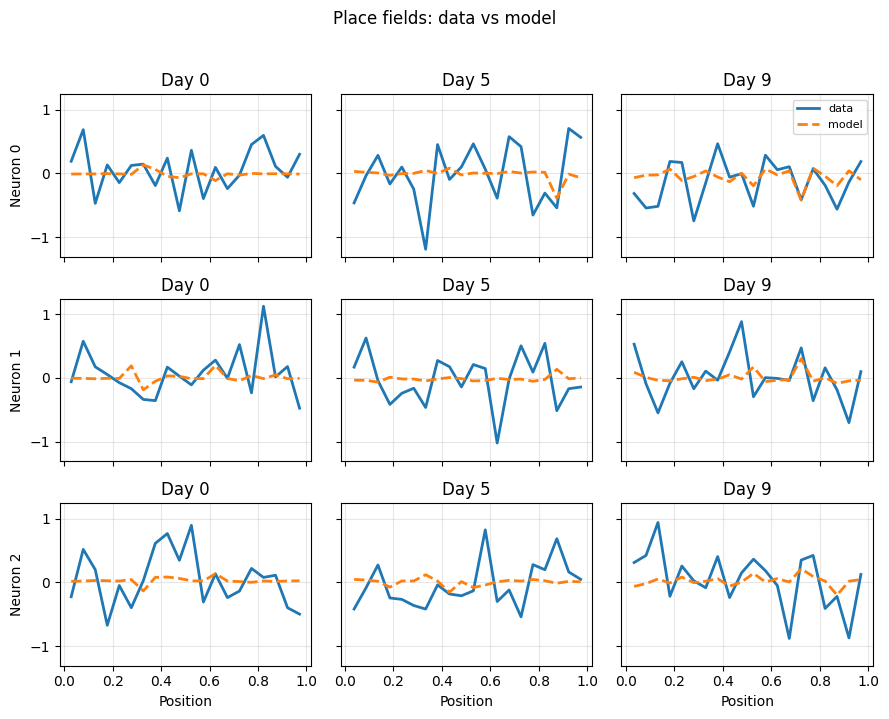

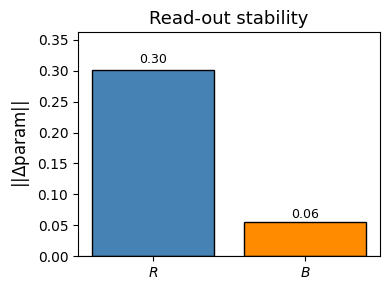

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

# ──────────────────────────────────────────────────────────────────────────────
# 1. Plot training loss curves
# ──────────────────────────────────────────────────────────────────────────────
def plot_loss_curves(hist):
    plt.figure(figsize=(5,4))
    for k, col in zip(['rec','dec','upd'], ['C0','C1','C2']):
        plt.plot(hist[k], label=k, color=col)
    plt.xlabel("Batch step")
    plt.ylabel("Loss")
    plt.legend(ncol=2, fontsize=8)
    plt.title("Training losses")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_loss_curves(loss_history)


# ──────────────────────────────────────────────────────────────────────────────
# Utilities for sessions
# ──────────────────────────────────────────────────────────────────────────────
def predict_session(model, data, Ws, t):
    """Return flat true & predicted positions, and flat x_obs/x_pred (trials×bins, N)."""
    y_true, y_pred = [], []
    X_obs, X_pred = [], []
    Wt = Ws[t]
    S_local = data.S
    for s in range(S_local):

        x0 = data.x[t,s].to(device)      # K×N
        v0 = data.v[t,s].to(device)      # K
        # roll out RNN
        x_list = [x0[0]]
        for k in range(K-1):
            up = model.rnn_cell(x_list[k], v0[k], Wt)
            x_list.append(up)
        x_pred = torch.stack(x_list, dim=0)  # K×N
        # flatten
        X_obs.append(x0.cpu().numpy())
        X_pred.append(x_pred.detach().cpu().numpy())
        # decode
        uhat = (model.R @ x_pred.t()).squeeze().detach().cpu().numpy()  # K
        y_pred.extend(uhat.tolist())
        y_true.extend(data.u[t,s].tolist())
    X_obs = np.concatenate(X_obs, axis=0)    # (S·K)×N
    X_pred = np.concatenate(X_pred, axis=0)
    return np.array(y_true), np.array(y_pred), X_obs, X_pred

# ──────────────────────────────────────────────────────────────────────────────
# 2. Decode accuracy (R²) over days
# ──────────────────────────────────────────────────────────────────────────────
r2s = []
for t in range(T):
    y_true, y_pred, *_ = predict_session(model, data, Ws, t)
    r2s.append(r2_score(y_true, y_pred))
plt.figure(figsize=(4,3))
plt.plot(range(T), r2s, '-o', color='C1')
plt.xlabel("Day t"); plt.ylabel("$R^2$"); plt.title("Decoding accuracy")
plt.ylim(0,1); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 3. Reconstruction error distribution per neuron
# ──────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
mse_per_day = []
for t in range(T):
    _, _, X_obs, X_pred = predict_session(model, data, Ws, t)
    mse_neuron = ((X_pred - X_obs)**2).mean(axis=0)  # N
    mse_per_day.append(mse_neuron)
# boxplot
plt.boxplot(mse_per_day, labels=[str(t) for t in range(T)], showfliers=False)
plt.xlabel("Day"); plt.ylabel("MSE per neuron"); plt.title("Reconstruction error")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 4. Latent-drift trajectories
# ──────────────────────────────────────────────────────────────────────────────
# re-compute z(t) on CPU
times = torch.arange(T, dtype=torch.float32, device="cpu")
z0_cpu = model.z0.detach().unsqueeze(0).cpu()
slow_cpu = model.slow.cpu()
z_cpu = odeint(slow_cpu, z0_cpu, times).squeeze(1)
z_cpu = z_cpu.detach().numpy()
plt.figure(figsize=(5,4))
for i in range(min(3, z_cpu.shape[1])):
    plt.plot(range(T), z_cpu[:,i], label=f"$z_{i+1}$")
plt.xlabel("Day t"); plt.ylabel("Latent $z$"); plt.title("Latent ODE drift")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 5. Subspace alignment: principal angles
# ──────────────────────────────────────────────────────────────────────────────
angles = []
for t in range(T):
    _, _, X_obs, X_pred = predict_session(model, data, Ws, t)
    pca = PCA(n_components=10)
    U_obs = pca.fit_transform(X_obs)[:, :3]     # S·K×3
    U_pred = PCA(n_components=10).fit_transform(X_pred)[:, :3]
    θ = subspace_angles(U_obs.T, U_pred.T)[0]  # smallest principal angle
    angles.append(θ)
plt.figure(figsize=(4,3))
plt.plot(range(T), angles, '-o', color='C2')
plt.xlabel("Day t"); plt.ylabel("Angle (rad)"); plt.title("Subspace angle")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 6. Place-field tuning curves (data vs model)
# ──────────────────────────────────────────────────────────────────────────────
def tuning_curve(x_flat, u_flat, nbins=20):
    bins = np.linspace(u_flat.min(), u_flat.max(), nbins+1)
    inds = np.digitize(u_flat, bins) - 1
    tc = np.zeros(nbins)
    for b in range(nbins):
        sel = inds==b
        tc[b] = x_flat[sel].mean() if sel.sum()>0 else np.nan
    return 0.5*(bins[:-1]+bins[1:]), tc

fig, axes = plt.subplots(3, 3, figsize=(9,7), sharex=True, sharey=True)
cells = [0,1,2]
days  = [0,5,9]
for i, c in enumerate(cells):
    for j, t in enumerate(days):
        y_true, y_pred, X_obs, X_pred = predict_session(model, data, Ws, t)
        # pick neuron c
        x_true = X_obs[:,c]; x_mod = X_pred[:,c]
        u_flat  = np.repeat(data.u[t].cpu().numpy().flatten(), 1)  # S·K?
        # Actually data.u[t] shape S×K; flatten directly
        u_flat = data.u[t].cpu().numpy().flatten()
        bins, tc_true = tuning_curve(x_true, u_flat)
        _,    tc_mod  = tuning_curve(x_mod, u_flat)
        ax = axes[i,j]
        ax.plot(bins, tc_true, '-', lw=2, label='data')
        ax.plot(bins, tc_mod,  '--', lw=2, label='model')
        if i==0 and j==2: ax.legend(fontsize=8)
        if i==2: ax.set_xlabel("Position")
        if j==0: ax.set_ylabel(f"Neuron {c}")
        ax.set_title(f"Day {t}")
        ax.grid(alpha=0.3)
plt.suptitle("Place fields: data vs model", y=1.02)
plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 7. Read-out stability (R, B norms)
# ──────────────────────────────────────────────────────────────────────────────
def plot_readout_stability(R_now, R_init, B_now, B_init):
    ΔR = (R_now - R_init).norm().item()
    ΔB = (B_now - B_init).norm().item()

    plt.figure(figsize=(4,3))
    bars = plt.bar(['$R$', '$B$'], [ΔR, ΔB],
                   color=['steelblue','darkorange'], edgecolor='black')

    # add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 1.02*height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.ylabel(r"$||\Delta \mathrm{param}||$", fontsize=12)
    plt.title("Read-out stability", fontsize=13)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.ylim(0, max(ΔR,ΔB)*1.2)  # add headroom
    plt.tight_layout()
    plt.show()

plot_readout_stability(model.R.detach(), initial_R,
                       model.B.detach(), initial_B)
